# Arvin Veerappan Final Project

### Introduction

I am going to be testing whether investing in an portfolio of high average dividend returns over the past year (during the pandemic), with monthly rebalancing, would yield a "winning" investment strategy when compared to the VTI index. I would start from April 15, 2009, and go until April 15, 2021 to have 12 years of data, and see how this portfolio compares to the benchmark VTI portfolio. I am picking this particular strategy because I want to see how a portfolio of high dividend returns would measure up to the benchmark because although these companies might not be as high growth as tech companies, they are attractive to investors because of the dividends they offer. They are also not as volatile as the high growth tech sector and might offer a safer strategy than QQQ for example, but we will see how this stacks up once we conduct the backtest. Additionally, out of the subset of 500 firms in the market that I chose with the highest average dividend returns over the past year, I would want to pick the 50 firms with the lowest beta to counter against the tumultuous conditions of the market since COVID-19 began.

In [1]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                          # To access websites.

import os

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'345f9b68c6ffee71bf7040a0ef988fc4ad262fc8'})
quandl.ApiConfig.api_key = 'Qj6jvrPgZc_xU5z4ytMy'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

SEC Data Function:

In [2]:
def ffill_values(item, dates):                                          
    data = item.unstack('cik')
    data = data.reindex(dates.union(data.index)).sort_index()           # Add specified dates to index.
    filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed']).filed
    last_filing_date_all_firms = filing_dates.max()                     # Most recent date where at least 1 firm filed.
     
    for cik in data.columns:                                            # Loop over all firms.
        last_filing_date      = pd.Series(filing_dates[cik]).iloc[-1]   # Last date where this firm filed
        days_since_last_filed = (last_filing_date_all_firms - last_filing_date).days
        last_date_this_firm   = dates[-1] if days_since_last_filed < 120 else last_filing_date
        data.loc[:last_date_this_firm, cik].ffill(inplace=True)         # Forward fill all the values.

    return data.loc[dates]                                              # Return only specified dates.  

Rebalance function:

In [3]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)



def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        assets        = select_assets(start_date)               # Call "select_assets()"  function to get the assets.
        start_weights = select_weights(start_date, assets)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

Select price, benchmark, and sales data

In [4]:
sales = pd.read_csv('data/sec/items/Sales.csv',  parse_dates=['filed'], index_col=['cik','filed'])


trading_days = pd.to_datetime( tiingo.get_dataframe('SPY','2009-4-15').index ).tz_convert(None)

salesQ = ffill_values( sales.valueQ,  trading_days )
salesA = ffill_values( sales.valueA,  trading_days )


symbols = pd.read_csv('data/ticker_symbols/symbols.csv',index_col=0)

SALESQ = salesQ.rename(columns=symbols.ticker)
SALESA = salesA.rename(columns=symbols.ticker)

PRICE  = pd.read_csv('data/tiingo/close.csv',    index_col='date', parse_dates=['date'])
RET    = pd.read_csv('data/tiingo/adjClose.csv', index_col='date', parse_dates=['date']).pct_change()  
VOLUME = pd.read_csv('data/tiingo/volume.csv',   index_col='date', parse_dates=['date'])
DIVIDEND  = pd.read_csv('data/tiingo/divCash.csv',    index_col='date', parse_dates=['date']).pct_change()
DOLLAR_VOLUME = VOLUME * PRICE

vti = tiingo.get_dataframe(['VTI'], '1990-1-1', metric_name='adjClose')
vti.index = pd.to_datetime(vti.index).tz_convert(None)
vti_ret = vti.pct_change().VTI

Now forward-fill the sales data to all trading days:

In [5]:
def ffill_values(item, dates):                                          
    data = item.unstack('cik')
    data = data.reindex(dates.union(data.index)).sort_index()           # Add specified dates to index.
    filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed']).filed
    last_filing_date_all_firms = filing_dates.max()                     # Most recent date where at least 1 firm filed.
     
    for cik in data.columns:                                            # Loop over all firms.
        last_filing_date      = pd.Series(filing_dates[cik]).iloc[-1]   # Last date where this firm filed
        days_since_last_filed = (last_filing_date_all_firms - last_filing_date).days
        last_date_this_firm   = dates[-1] if days_since_last_filed < 120 else last_filing_date
        data.loc[:last_date_this_firm, cik].ffill(inplace=True)         # Forward fill all the values.

    return data.loc[dates]                                              # Return only specified dates.   



trading_days = pd.to_datetime( tiingo.get_dataframe('SPY','1900-1-1').index ).tz_convert(None)

salesQ = ffill_values( sales.valueQ,  trading_days )
salesA = ffill_values( sales.valueA,  trading_days )

Now we need to change the column labels from CIKs to ticker symbols:

In [6]:
symbols = pd.read_csv('data/ticker_symbols/symbols.csv',index_col=0)

SALESQ = salesQ.rename(columns=symbols.ticker)
SALESA = salesA.rename(columns=symbols.ticker)

Backtest Function:

In [7]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)



def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        assets        = select_assets(start_date)               # Call "select_assets()"  function to get the assets.
        start_weights = select_weights(start_date, assets)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

Betas for all firms:

In [8]:
n = 252

firms = PRICE.columns
start = PRICE.index[0]
end   = PRICE.index[-1]

var = vti_ret.rolling(n).var()

BETA = pd.DataFrame()

for firm in firms:
    cov        = RET[firm].rolling(n).cov(vti_ret) 
    BETA[firm] = cov / var
    
BETA = BETA[start:end]
BETA

,AIR,ABT,WDDD,ACU,AE,BKTI,AMD,AEM,APD,APRCP,...,GGPIU,NECB,HITIF,AYRWF,OUTR,GIW,ABCO,NHLDW,ENGMF,CGAU
2009-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-13,2.118640,0.644229,0.637885,0.426704,0.839602,0.462180,1.203143,0.411725,0.873042,-0.016419,...,NaN,0.285076,1.330279,NaN,1.213967e-16,5.386682e-19,4.476557e-16,0.075675,0.596426,NaN
2021-04-14,2.157536,0.627605,0.476072,0.426066,0.838726,0.626483,1.172730,0.405311,0.877449,-0.016522,...,NaN,0.294279,1.329151,NaN,1.240144e-16,5.502833e-19,4.573084e-16,0.092260,0.595469,NaN
2021-04-15,2.139149,0.654889,0.513148,0.437620,0.840409,0.636852,1.203493,0.417864,0.871474,-0.017045,...,NaN,0.294859,1.339083,NaN,1.259350e-16,5.588054e-19,4.643906e-16,0.077797,0.559417,NaN
2021-04-16,2.141854,0.650896,0.509136,0.441299,0.843230,0.636367,1.200947,0.416519,0.872092,-0.017031,...,NaN,0.298726,1.348668,NaN,1.259604e-16,5.589185e-19,4.644845e-16,0.113330,0.561965,NaN


<AxesSubplot:>

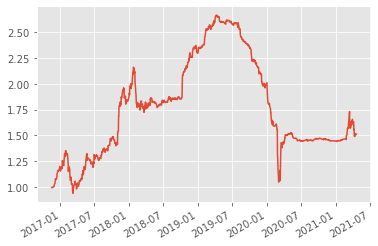

In [9]:
#Example
BETA.SQ.plot()  # same graph as above

Among 500 firms with highest average dividend returns during the last 252 trading days, select the 50 firms with lowest beta:

<AxesSubplot:>

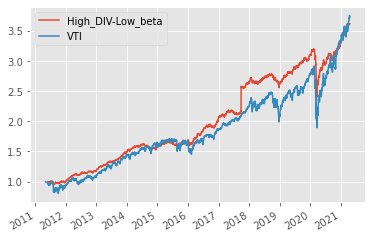

In [10]:
def select_assets(date):
    high_div = DIVIDEND[:date][-252:].mean().nlargest(500).index
    assets      = BETA[high_div][:date].iloc[-1].nsmallest(50).index
    return assets

def select_weights(date, assets):            
    return pd.Series(1/len(assets), index=assets)  

high_div_low_beta, weights, trades = run_backtest('month', '2011-5-1')

t = high_div_low_beta.to_frame('High_DIV-Low_beta').join(vti_ret)
t.add(1).cumprod().plot()#(logy=True)

<AxesSubplot:>

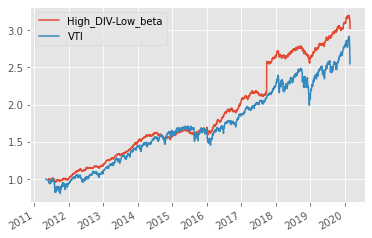

In [11]:
#This was a "winning" strategy (with the exception of a brief period in 2016) until the pandemic hit in March 2020
t.add(1).cumprod().loc[:'2020-3-1'].plot()

<AxesSubplot:>

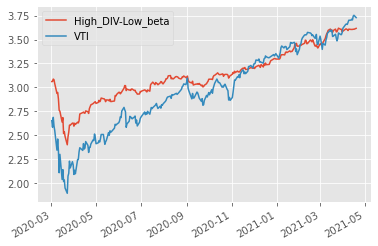

In [12]:
#Since the COVID-19 pandemic started, this strategy fell but kept in line with the VTI until around the election time in November. 
#Since the election and the transition of power, this strategy has proved to not be a winning one in comparison to VTI
#The key risk of this strategy is that companies who typically pay high dividends aren't investing as much of their free cash flows back into the business to fuel growth
#They're more stable, value based companies. This is contrary to the more appealing high-growth tech companies that can swing markets.
t.add(1).cumprod().loc['2020-3-1':].plot()

Calculate the beta of this portfolio:

In [13]:
high_div_low_beta.cov(vti_ret) / vti_ret[high_div_low_beta.index[0]:high_div_low_beta.index[-1]].var()

0.21763687821234048

Volatilities

<AxesSubplot:>

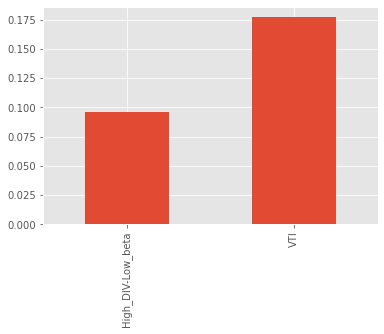

In [14]:
vol = t.std()*252**0.5
vol.plot.bar()

Rolling beta of the portfolio:

<AxesSubplot:>

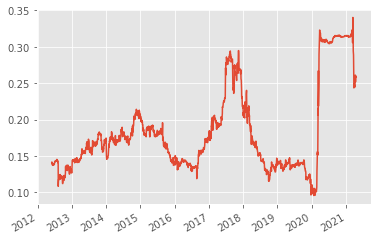

In [15]:
cov = high_div_low_beta.rolling(252).cov(vti_ret)
var = vti_ret.rolling(252).var()
(cov / var).plot()

### Conclusion

In summary, this high dividend return, low beta backtest strategy was a winner, in comparison to the benchmark VTI index, until the 2020 Presidential Election. The VTI really started to catch up around the time the Coronavirus Pandemic ensued in March 2020, but it wasn't until November 2020 that we saw this strategy get passed by VTI. Typically, when companies pay high dividends they are in general in stable financial health and the dividend payment makes demand go up by attracting more investors. Coupled with a low beta, a portfolio made of these stocks will not fluctuate with market swings and offer nice dividends for holding the stocks. However, since the Biden administration has taken over this strategy has not worked over the past 6 months and may take another few months to surpass the VTI. This is likely because the tech sector, which are typically high-growth firms with low dividend returns and high betas, are dominating the market environment. This has especially been the case with more investors learning about the Crypto market and companies adopting to the digital pivot COVID-19 has forced them to make. This means that instead of paying out their cash to investors, companies reinvest that cash back in the business to fuel even more growth or to gain a competitive edge, particularly in crowded spaces like Fintech.